## Summary

In this lesson, Jeremy walks through a bird classification example which back in 2015 was considered the bleeding edge of state of the art. 8 years later, it's hard to believe that I can run this on my own local machine. Even though my training is in computer science, I found some of the definitions and the code in this lesson challenging which is where Chapter 1 was really helpful. I would strongly recommend checking out the definitions in this chapter because they are still used today when talking about more advanced models like GPT-4.

## Terminology

-   **Machine Learning** - The training of programs developed by teaching a computer learn from experience rather than coding the individual steps

-   **Deep Learning** - A computer technique that uses layers of neural networks to extract and transform data. Neural networks layers are trained by algorithms that minimize their errors and improve their accuracy. This is how a network learns to perform a specific task. Deep learning is a sub-discipline of `machine learning`.

-   **Dataset** - A bunch of data ie. images, sounds, text, files or anything else.

-   **Label** - The data we're trying to predict ie. dog or cat.

-   **Independent Variable** - Data that does not include labels

-   **Dependent Variable** - the correct label ie. dog or cat. Also called **targets.**

-   **Architecture** - The structure of the model we're trying to fit. A mathematical function that we're passing the input data and parameters to.

-   **Parameters** - The values in the model that change what task it can do and are updated through model training. In Arthur Samuel's definitions the synonym for parameters is weights which has a different meaning in modern deep learning.

-   **Parameter(Weight) Assignment** - Particular choice of values for parameters.

-   **Weights** - A particular type of model parameter.

-   **Fit** - Update the model parameters such that the predictions of the model using the input data match the target labels.

-   **Train** - Synoym for fit.

-   **Pretrained Model** - A model that has already been trained, generally using a large dataset and will be fine-tuned ie. resnet class of models.

-   **Fine-Tune** - Update a pretrained model for a different task.

-   **Epoch** - One complete pass through the input data.

-   **Loss** - A measure of how good the model is, chosen to drive training via `Stochastic Gradient Descent (SGD)`.

-   **Metric** - A measurement of how good the model is, using the validation set, chosen for human consumption.

-   **Validation Set** - A set of data held out from training, used only for measuring how good the model is.

-   **Training Set** - The data used for fitting the model; does not include any data from the validation set.

-   **Overfitting** - Training a model in such a way that it remembers specific features of the input data rather than generalizing.

-   **Convolutional Neural Network (CNN)** - A type of neural network that works particularly well for computer vision tasks.

-   **Transfer Learning** - Using a pretrained model for a task different to what it was originally trained for.

-   **Head Layer** - When using a pretrained model, replace the last layer with one or more layers with randomized weights of an appropriate size for the dataset you are working with. This customizes a model specifically for your task when using a pretrained model.

## Limitations of Machine Learning

1.  A model cannot be created without data
2.  A model can only learn to operate on patterns seen in input data used to train it
3.  This learning approach only creates `predictions` **not** `recommend actions`
4.  We need `labels` + `data` (pictures of dogs and cats that have labels saying which ones are dogs and which ones are cats)

## Is It a Bird? Example

The following code in this example is created and written by Jeremy Howard and FastAI as found in the example [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data). My modification was adding comments for myself to the data block section so that I could understand what each part of the datablock is doing.

In [1]:
import os 
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

### Step 1: Gather Data

In [2]:
from duckduckgo_search import ddg_images 
from fastcore.all import * 

# helper function for searching for images 
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://images.alphacoders.com/492/492674.jpg'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


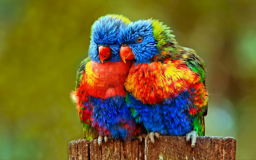

In [4]:
from fastdownload import download_url 
from fastai.vision.all import *
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256, 256)



Searching for 'forest photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


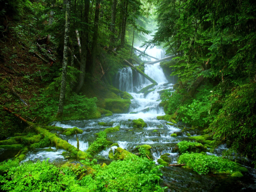

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', 
             show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

In [6]:
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep 

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10) # sleep between searches to avoid spamming server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10) # sleep between searches to avoid spamming server 
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10) # sleep between searches to avoid spamming server 
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


### Step 2: Train Model 

In [8]:
# remove images that failed to download properly 
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

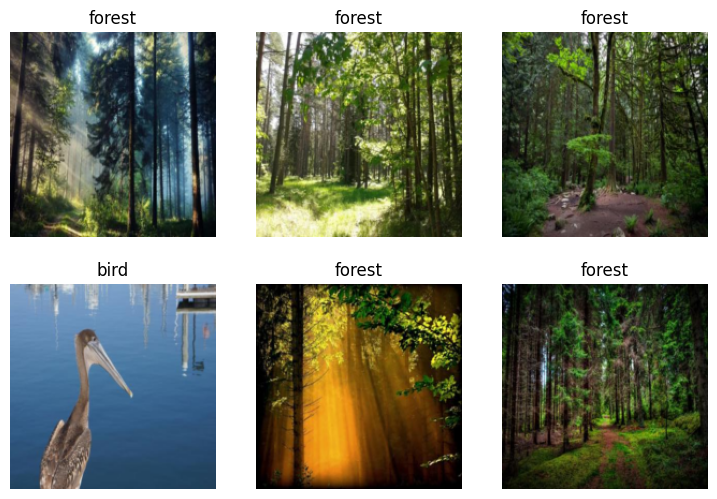

In [14]:
# split data into training set, validation set 
dls = DataBlock(
    # specify input type(image), output type(category aka label)
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    # split data into 80% training data, and 20% validation data
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # define the label 
    get_y=parent_label,
    # standardize and resize all images to 192 x 192
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [18]:
# train resnet on the data
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.744936,0.402673,0.156250,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.178611,0.097689,0.031250,00:01
1,0.117756,0.136063,0.031250,00:01
2,0.079709,0.154602,0.031250,00:01


### Step 3: Test Model

In [19]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a : {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a : bird.
Probability it's a bird: 0.9996


## Picasso Cubist Painting or Georges Bracques Cubist Painting

This code was written by me based on Jeremy and FastAI's bird example. I picked this example because of an interest in art, the similarity between Picasso and Braque's cubist art, and the question of whether a 
computer would be able to tell the difference between the two artists when shown a random cubist painting by either Picasso or Braque. 

### Step 1: Gather Data 

In [20]:
urls = search_images('Pablo Picasso Cubist Painting', max_images=1)
urls[0]

Searching for 'Pablo Picasso Cubist Painting'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'http://www.baaqii.com/promanage/productimage/OP/OP0288.jpg'

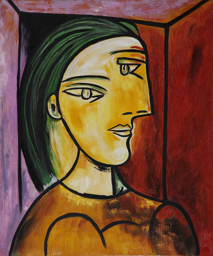

In [21]:
from fastdownload import download_url 
from fastai.vision.all import *
dest = 'picasso.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256, 256)


Searching for 'George Braque Cubist Painting'


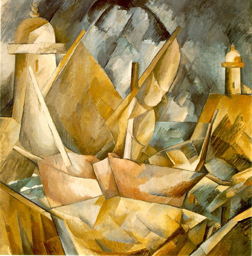

In [22]:
download_url(search_images('George Braque Cubist Painting', max_images=1)[0], 
             'braque.jpg', 
             show_progress=False)
Image.open('braque.jpg').to_thumb(256, 256)

In [27]:
searches = 'Pablo Picasso', 'George Braque'
path = Path('picasso_or_braque')
from time import sleep 

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} cubist painting'))
    sleep(10) # sleep between searches to avoid spamming server
    download_images(dest, urls=search_images(f'{o} fauvist painting'))
    sleep(10) # sleep between searches to avoid spamming server 
    download_images(dest, urls=search_images(f'{o} geometric painting'))
    sleep(10) # sleep between searches to avoid spamming server 
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Pablo Picasso cubist painting'
Searching for 'Pablo Picasso fauvist painting'
Searching for 'Pablo Picasso geometric painting'
Searching for 'George Braque cubist painting'
Searching for 'George Braque fauvist painting'
Searching for 'George Braque geometric painting'


### Step 2: Train Model

In [28]:
# remove images that failed to download properly 
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

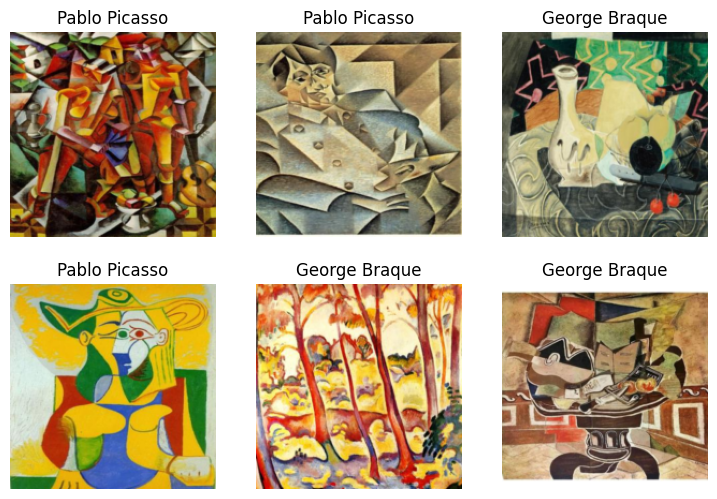

In [29]:
# split data into training set, validation set 
dls = DataBlock(
    # specify input type(image), output type(category aka label)
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    # split data into 80% training data, and 20% validation data
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # define the label 
    get_y=parent_label,
    # standardize and resize all images to 192 x 192
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [30]:
# train resnet on the data
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.963409,0.409861,0.157143,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.281930,0.232642,0.057143,00:01
1,0.227495,0.084337,0.028571,00:01
2,0.163790,0.051675,0.014286,00:01


### Step 3: Test Model

There is something wrong here because the probability is incorrect. I can't figure out whether I messed up in the data phase, architecture choice (resnet34 instead of resnet18), or a programming mistake. My guess 
is that program should have a probability of choosing the right result around the same percentage as the bird example. If anyone knows what the issue might be, please reach out.

In [32]:
is_picasso,_,probs = learn.predict(PILImage.create('picasso.jpg'))
print(f"This is a: {is_picasso}.")
print(f"Probability it's a picasso: {probs[0]:.4f}")

This is a: Pablo Picasso.
Probability it's a picasso: 0.0006


## Resources 

1.  [FastAI Lesson 1: Getting Started](https://course.fast.ai/Lessons/lesson1.html)
2.  [FastAI Chapter 1, Intro](https://colab.research.google.com/github/fastai/fastbook/blob/master/01_intro.ipynb)
3.  [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data)
4.  [Jupyter Notebook 101](https://www.kaggle.com/code/jhoward/jupyter-notebook-101)
5.  [FastAI Docs](https://docs.fast.ai/tutorial.vision.html)